In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import json
from ipywidgets import IntSlider, interact
from scipy import stats
import geopandas as gpd
import pandas_bokeh

pandas_bokeh.output_notebook()

Loading BokehJS ...

In [2]:
# do that: conda install -c conda-forge umap-learn
import umap
from sklearn import preprocessing
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Analysis of fertilizer efficiency on agriculture production
## Handling data
First lets import the 2 dataset from FAO :
* One about agriculture production containing (among others data) the yield per crops and per country : Crops from http://www.fao.org/faostat/en/#data/QC
* The other about fertilizer containing quantity used of 3 different fertilizers per area of cropland (from 2002 to 2016): Fertilizers indicators from http://www.fao.org/faostat/en/#data/EF 

In [3]:
#importing FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

### 1) Fertilizer
We start by taking a look at fertilizer dataset and the type of data contained by it

In [4]:
fertilizer_area.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc


In [5]:
# Looking at the range of year covered by fertilizer dataframe
mini=min(fertilizer_area.Year)
maxi=max(fertilizer_area.Year)
print('Period of time covered by fertilizer_area : %d to %d'%(mini,maxi))

Period of time covered by fertilizer_area : 2002 to 2016


In [6]:
# looking at each type of fertilizer (and associated code)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [7]:
# Take a look at how many countries this dataset has values from
fertilizer_area.Area.unique().size

197

In [8]:
# Take a look at missing value in fertilizer_area dataset
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


Is there really 0 missing value or is the value equal to zero when missing ?


In [9]:
fertilizer_area[fertilizer_area.Value ==0].head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
25,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2013,2013,kg/ha,0.0,Fc
26,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2014,2014,kg/ha,0.0,Fc
27,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2015,2015,kg/ha,0.0,Fc
28,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2016,2016,kg/ha,0.0,Fc
59,3,Albania,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2002,2002,kg/ha,0.0,Fc


We can see some countries have 0 values for some years so let's take a deeper look :

In [10]:
fertilizer_area[fertilizer_area.Area == 'Afghanistan'].tail(8)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
21,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2013,2013,kg/ha,0.19,Fc
22,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2014,2014,kg/ha,0.19,Fc
23,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2015,2015,kg/ha,0.19,Fc
24,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2016,2016,kg/ha,0.19,Fc
25,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2013,2013,kg/ha,0.00,Fc
26,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2014,2014,kg/ha,0.00,Fc
27,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2015,2015,kg/ha,0.00,Fc
28,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2016,2016,kg/ha,0.00,Fc


We only have value for 4 years for potash nutrient afghanistan's use so it looks like they are missing values.
How many values are in that situation ?

In [11]:
# Taking a look for Nitrogen nutrient
overall =fertilizer_area.query('`Item Code`==3102').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3102').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3102').Area.unique().shape


print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2831 values with 26 equal to zero from 10 countries


In [12]:
# Taking a look for phosphate nutrient
overall =fertilizer_area.query('`Item Code`==3103').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3103').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3103').Area.unique().shape
print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2800 values with 40 equal to zero from 17 countries


In [13]:
# Taking a look for potash nutrient
overall =fertilizer_area.query('`Item Code`==3104').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3104').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3104').Area.unique().shape

print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2777 values with 56 equal to zero from 28 countries


There are only a few values missing from about 10% of the countries. We could just drop them but before doing it, we can use interpolation to replace values for countries where only a few years are missing. 
However, we need to check wether it is a reasonable approximation to interpolate the use of fertilizer over the year (i.e verify the linearity of the evolution) :


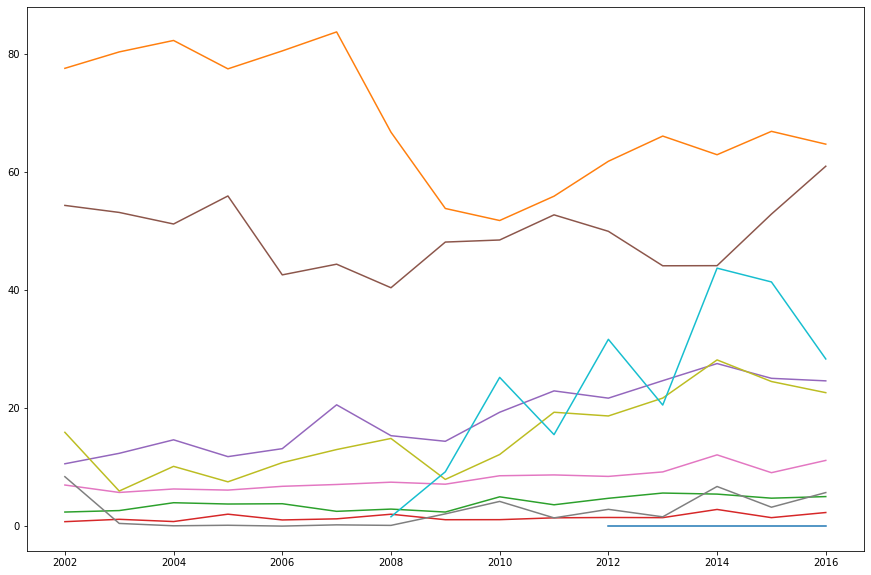

In [14]:
# Visual check of fertilizer evolution over the years
fig = plt.figure(figsize = (15, 10))
for area in fertilizer_area.sample(n=10).Area.unique()[:10]:
    a=fertilizer_area.query('Area == @area and `Item Code`==3102')
    x=a.Year
    y=a.Value
    plt.plot(x,y)
    

From the previous plot and because we will only care about the magnitude of fertilizer use in our analysis, it seems correct to interpolate missing values.
To do so we need also to look at the (missing values/total values) ratio for each country and if it is too high (thus interpolation would be meaningless) we will just drop these values :

In [15]:
# Compute ratio of missing values for areas and items
ratio=[]
for item in ferti_items['Item Code'].values : 
    missing_area=fertilizer_area.query('Value==0').query('`Item Code`==@item').Area.unique()

    for area in missing_area :
        m=(fertilizer_area.query('Area==@area')
        .query('Value==0')
        .query('`Item Code`==@item')
        .Value.count())
        n=(fertilizer_area.query('Area==@area')
        .query('`Item Code`==@item')
        .Value.count())
        ratio.append([area,item,float(m/n)])

ratio=pd.DataFrame(ratio, columns=['Area','Item Code','Ratio'])
print(fertilizer_area.shape[0])
print(ratio.shape[0])
ratio.head()


8408
55


,Area,Item Code,Ratio
0,Antigua and Barbuda,3102,0.066667
1,Benin,3102,0.066667
2,Libya,3102,0.066667
3,Lithuania,3102,0.133333
4,Marshall Islands,3102,1.000000


<font color='red'>Other probleme : this programme doesn't take care of real missing value, we could add the interpolation from after where we actually replace missing values</font>

Now that we have our ratio dataset, let's drop or interpolate the missing values :

In [16]:
#interpolation of fertilizer missing values
na=fertilizer_area.query('Value == 0').shape
print("There were %d missing values"%na[0])

for item in ferti_items['Item Code'].values : 
    # Step 1 : drop area which have more than 50% of 0 values
    to_drop=fertilizer_area[fertilizer_area.Area.isin(ratio.query('Ratio>0.5 and `Item Code`==@item').Area)].query('`Item Code`==@item and Value == 0').index
    fertilizer_area.drop(to_drop,inplace=True)
    #Step 2 :creating 2 dataset : one contains area and year with missing value, the other is the dataset with all missing values dropped
    missing_ferti=fertilizer_area.query('Value == 0 and `Item Code` == @item')
    dropnan_ferti=fertilizer_area.query('Value != 0').query('`Item Code` ==@item')
    #step 3 : interpolation :
    for x in missing_ferti.Area.unique() :
        interpolation_coef = np.polyfit(dropnan_ferti.query('Area == @x').Year,dropnan_ferti.query('Area == @x').Value,1)
        poly = np.poly1d(interpolation_coef)
        to_replace=fertilizer_area.index[(fertilizer_area.Area==x)&(fertilizer_area['Item Code']==item)&(fertilizer_area.Value == 0)]
        replacing=poly(fertilizer_area.iloc[to_replace].Year)
        df=pd.DataFrame({'Value':replacing},index=to_replace)
        fertilizer_area.update(df,overwrite=True)

na=fertilizer_area.query('Value == 0').shape
print("There are %d missing values"%na[0])

#finaly replace negative value from interpolation by 0
to_replace=fertilizer_area.index[fertilizer_area.Value < 0]
fertilizer_area.loc[fertilizer_area.Value<0,'Value']=0

There were 122 missing values
There are 0 missing values


## 2) Crop dataset
Only selected grouped crops are selected because in order to use ML algorithm it is necessary to have independant features (and grouped crops are more likely to regroup all dependents features together).

Firsty, lets take a look at yield for each country on year 2004 (arbitraly set) :


In [17]:
crop_corr=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == 2004')
        .query('`Item Code` >1000')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
print(crop_corr.shape[0])
crop_corr.head()

244


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


We can see that there are some missing value (either due to missing values in the crops dataset or to unproduced crops by a country).
How many are there ?

In [18]:
# Checking in which columns values are missing for 1 year
print(crop_corr.isnull().sum()[crop_corr.isnull().sum()!=0])

Item
Cereals (Rice Milled Eqv)     27
Cereals,Total                 27
Citrus Fruit,Total            72
Coarse Grain, Total           31
Fibre Crops Primary           90
Fruit Primary                  6
Oilcrops, Cake Equivalent     18
Oilcrops, Oil Equivalent      16
Pulses,Total                  39
Roots and Tubers,Total         7
Treenuts,Total               100
Vegetables Primary             6
dtype: int64


We can expand that analysis at all the years :

In [19]:
# count total of missing values for all years
miss_count=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419')
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area Code',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Year','Total_row']+crop_year.columns.values.tolist()
    values=[year, crop_year.shape[0]]+crop_year.isnull().sum().values.tolist()
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count=miss_count.append(df)
miss_count.sum()

C:\Users\juleb\.conda\envs\ada\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Area Code                        0.0
Cereals (Rice Milled Eqv)      389.0
Cereals,Total                  389.0
Citrus Fruit,Total            1063.0
Coarse Grain, Total            448.0
Fibre Crops Primary           1154.0
Fruit Primary                   88.0
Oilcrops, Cake Equivalent      229.0
Oilcrops, Oil Equivalent       194.0
Pulses,Total                   554.0
Roots and Tubers,Total         103.0
Total_row                     3149.0
Treenuts,Total                1486.0
Vegetables Primary              88.0
Year                         30135.0
dtype: float64

### Interpolating missing value 
1) creating a dataset pointing to missing values and another with all missing value dropped

In [20]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [21]:
ferti_range=pd.Series(range(2002,2016+1,1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()
        

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [22]:
missing_values.shape[0]

2807

In [23]:
#NCreating the 2nd dataset
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

2) Executing the interpolation

In [24]:
'''count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x').Item.unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value = poly(year)
                template = (dropnan_crops.query('`Area Code` == @x')
                                        .query('`Item` == @j').head(1))
                to_add = template.values
                to_add[0][9] = interp_value
                to_add[0][6] = year
                to_add[0][7] = year
                to_add=pd.DataFrame(to_add, columns=template.columns.values)
                crops=crops.append(to_add, ignore_index=True, sort=False)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print("The operation replaced %d values"%count)
'''

'count=0\n#Purpose of this code : adding missing value by interpolation \nfor x in missing_values[\'Area Code\'].unique():\n    for j in missing_values.query(\'`Area Code` == @x\').Item.unique():\n        if dropnan_crops.query(\'`Area Code` == @x\').query(\'`Item` == @j\').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values\n            interpolation_coef = np.polyfit(dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Year,\n                                            dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Value,\n                                            1)\n            poly = np.poly1d(interpolation_coef)\n            for year in missing_values.query(\'`Area Code` == @x\').query(\'`Item` == @j\').Year.values:\n                interp_value = poly(year)\n                template = (dropnan_crops.query(\'`Area Code` == @x\')\n                                        .query(\'`Item` == @j\').head(1)

#### Saving modified crops to avoid re-running the interpolation

In [25]:
#crops.to_pickle("crops_interpolated") # uncomment to save again the pickle

In [26]:
crops=pd.read_pickle("crops_interpolated")

In [27]:
# To avoid duplicated index or other index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


3) Checking changed values 

In [28]:
area_indexed2=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed2.head()

Area Item Code Element Code  \
Area Code Item                                                            
2         Cereals (Rice Milled Eqv)  Afghanistan      1817         5419   
          Cereals (Rice Milled Eqv)  Afghanistan      1817         5419   
          Cereals (Rice Milled Eqv)  Afghanistan      1817         5419   
          Cereals (Rice Milled Eqv)  Afghanistan      1817         5419   
          Cereals (Rice Milled Eqv)  Afghanistan      1817         5419   

                                    Element Year Code  Year   Unit  Value Flag  
Area Code Item                                                                  
2         Cereals (Rice Milled Eqv)   Yield      1961  1961  hg/ha  10831   Fc  
          Cereals (Rice Milled Eqv)   Yield      1962  1962  hg/ha  10480   Fc  
          Cereals (Rice Milled Eqv)   Yield      1963  1963  hg/ha   9548   Fc  
          Cereals (Rice Milled Eqv)   Yield      1964  1964  hg/ha  10461   Fc  
          Cereals (Rice Milled Eqv)   Yield      1965  1965  hg/ha  10621   Fc

In [29]:
area_indexed2.shape[0]-area_indexed.shape[0]

1371

In [30]:
ferti_range=pd.Series(range(2002,2016+1,1))
missing_values2=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed2.index.get_level_values(level=0).unique().values:
    for item in area_indexed2.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed2.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values2 =missing_values2.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values2.head()

,Area Code,Item,Year
0,11,"Treenuts,Total",2002
1,11,"Treenuts,Total",2003
2,11,"Treenuts,Total",2004
3,11,"Treenuts,Total",2005
4,11,"Treenuts,Total",2006


In [31]:
miss_count2=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Year','Total_row']+crop_year.columns.values.tolist()
    values=[year, crop_year.shape[0]]+np.round(crop_year.isnull().sum().values).tolist()
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count2=miss_count2.append(df, sort=False)
miss_count2.sum()



Year                         30135
Total_row                     3184
Area                             0
Cereals (Rice Milled Eqv)      390
Cereals,Total                  390
Citrus Fruit,Total            1065
Coarse Grain, Total            450
Fibre Crops Primary           1346
Fruit Primary                   90
Oilcrops, Cake Equivalent      279
Oilcrops, Oil Equivalent       234
Pulses,Total                   555
Roots and Tubers,Total         105
Treenuts,Total                1500
Vegetables Primary              90
dtype: int64

In [32]:
miss_count

,Area Code,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Total_row,"Treenuts,Total",Vegetables Primary,Year
0,0,26,26,72,30,87.0,6,18.0,16.0,38,7,209,101,6,2002
0,0,26,26,72,30,87.0,6,18.0,16.0,37,7,209,101,6,2003
0,0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2004
0,0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2005
0,0,27,27,71,30,90.0,6,18.0,15.0,37,7,210,99,6,2006
0,0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,99,6,2007
0,0,26,26,71,30,90.0,6,18.0,15.0,37,7,210,98,6,2008
0,0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,98,6,2009
0,0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2010
0,0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2011


In [33]:
miss_count2

,Year,Total_row,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,2002,213,0,26,26,71,30,89,6,19,16,37,7,100,6
0,2003,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2004,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2005,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2006,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2007,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2008,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2009,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2010,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,2011,212,0,26,26,71,30,90,6,19,16,37,7,100,6


One can notice from the first table that there were 3 columns with NaN value. By construction it's due to the fact there werent any data for these crops for 2015 and 2016. The interpolation program extrapolated for these two years thus allowing us to carry out machine learning on all years. Having the same number of features for each year will also allow us to compare the results between years after having executed post-processing operations.

### Correlation between crops production

For an efficient use of machine learning algorithms, it is also needed to have independant features. Therefore, let's take a look at the correlation heatmap between features :

Text(0.5, 1, "Correlation matrix of the features of the dataset 'fifa_train'.")

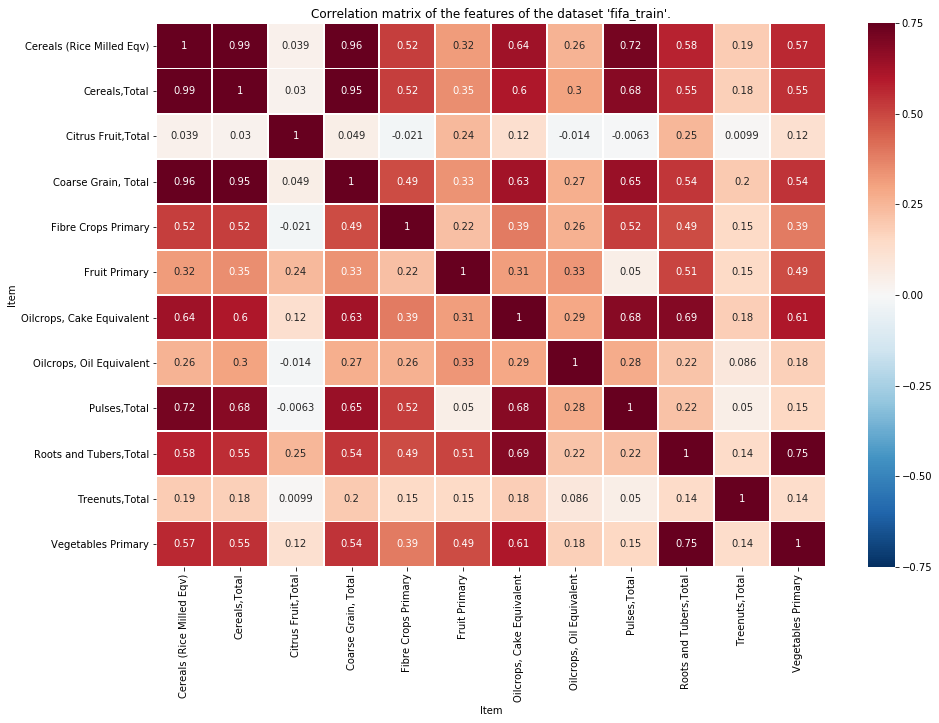

In [34]:
# We did corelation on one year
correlation = crop_corr.corr()

# Plotting correlation map
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(correlation, annot=True, linewidths=1, center=0,\
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
plt.title("Correlation matrix of the features of the dataset 'fifa_train'.")

It can be observed that cereals are strongly correlated. It is therefore necessary to merge them.
One can also notice that except citrus, there isn't any features negatively correlated to one another which seems consistent with agriculture.


## Dimensionality reduction 


In order to observe the impact of fertilizers on agriculture. It is necessary to compute an indicator of that performance. Dimensionality reduction on yield for each crop and each country will compute an indicator (best explaining the difference between all yields of each country).

2 different algorithms for dimensionality reduction will be used :
* Umap because it can capture non-linear relations
* PCA because it gives us informations about the importance of each feature through coefficients


### Umap reduction

In [35]:
# This function separate countries in tree different groups function of their fertilizer's use
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizers values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

Definition ot the function calculating the umap reduction :

Inputs : year, 1 fertilizer and for 1 or more final dimension(s).

Outputs : computed year, a dataframe with Umap score as well as fertilizer value for each ountry and coeficcient from a linear interpolation of the result (fertilizer value vs umap score)


In [36]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .query('Value > 0')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Now that functions are defined, let's take a look at fertilizer use ploted against the umap projection over the year. The linear interpolation is also plotted.

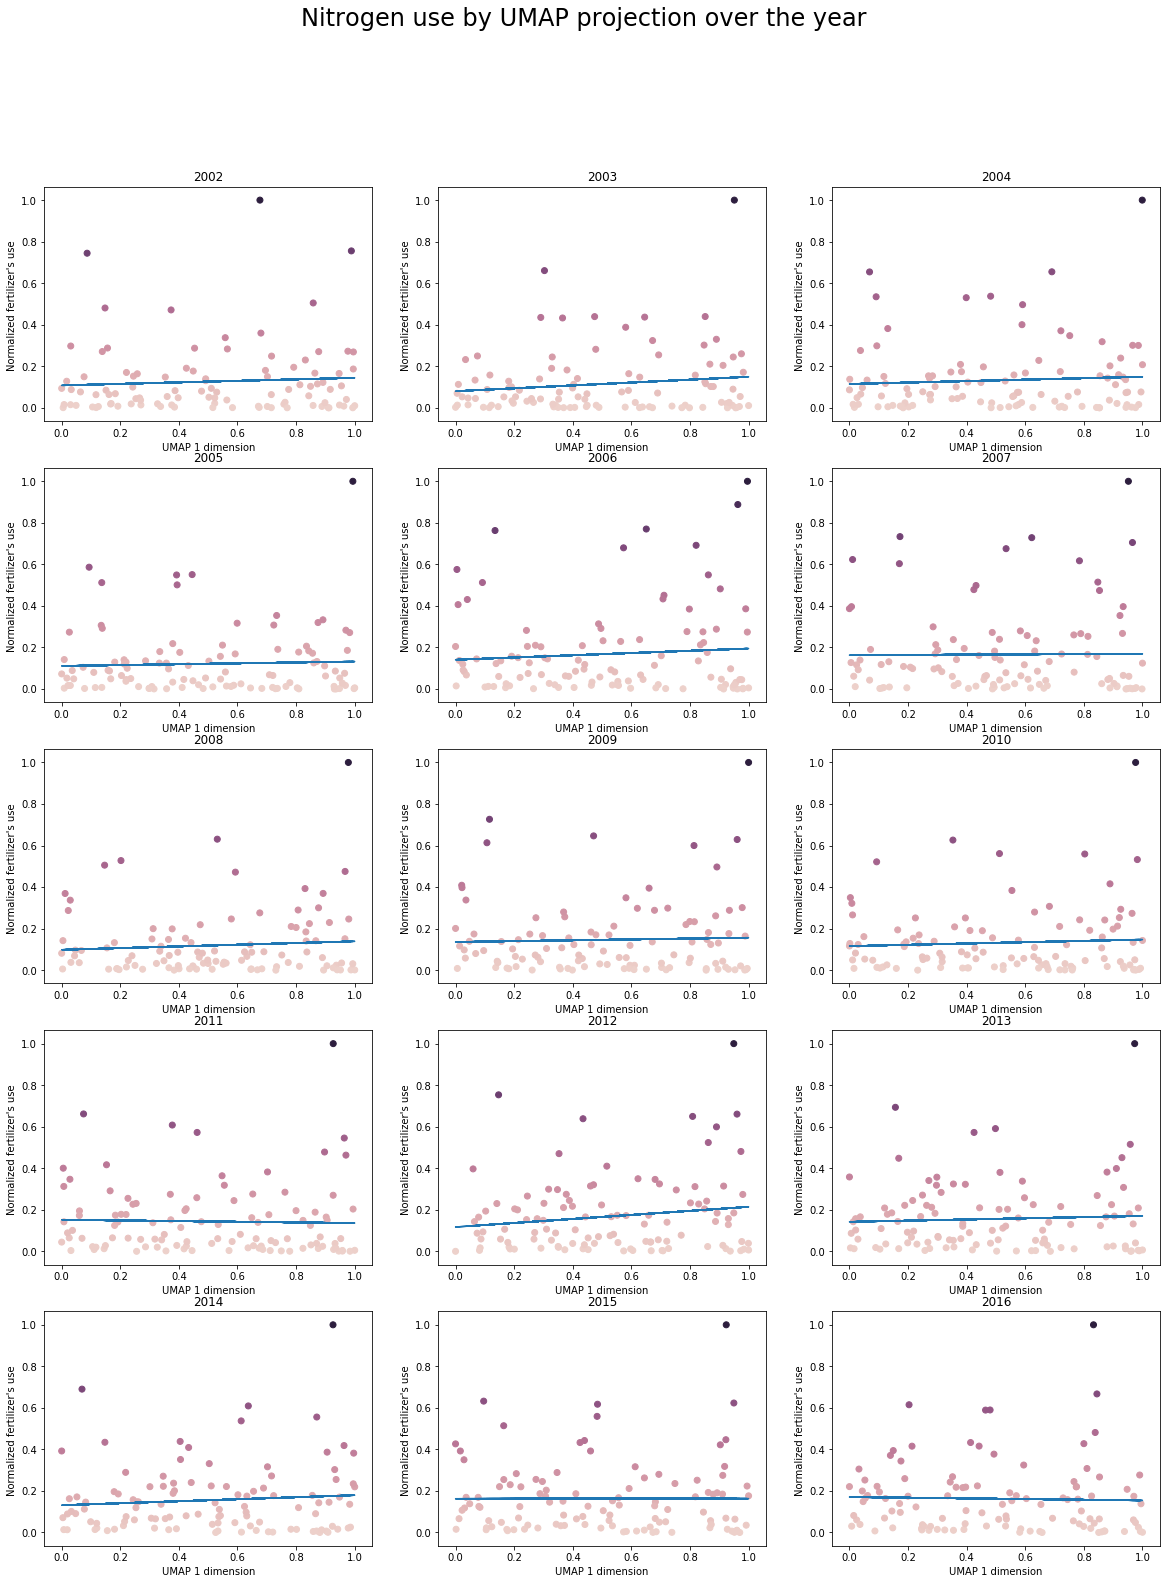

In [37]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3102, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2['Umap'], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2['Umap'], poly1d_fn(embedding2['Umap']))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

The correlation between Umap and fertilizer use is weak.

LinregressResult(slope=-0.0021809618797826056, intercept=4.4120444708317095, rvalue=-0.32068536165110273, pvalue=0.24387205227754388, stderr=0.0017866209868382544)
LinregressResult(slope=-0.010596170979993987, intercept=21.262774780334933, rvalue=-0.8808956212016082, pvalue=1.4473207563978028e-05, stderr=0.0015790614895106006)
LinregressResult(slope=-0.007706074535770999, intercept=15.50887054844578, rvalue=-0.579313360517922, pvalue=0.023624928146120043, stderr=0.003007194365965577)


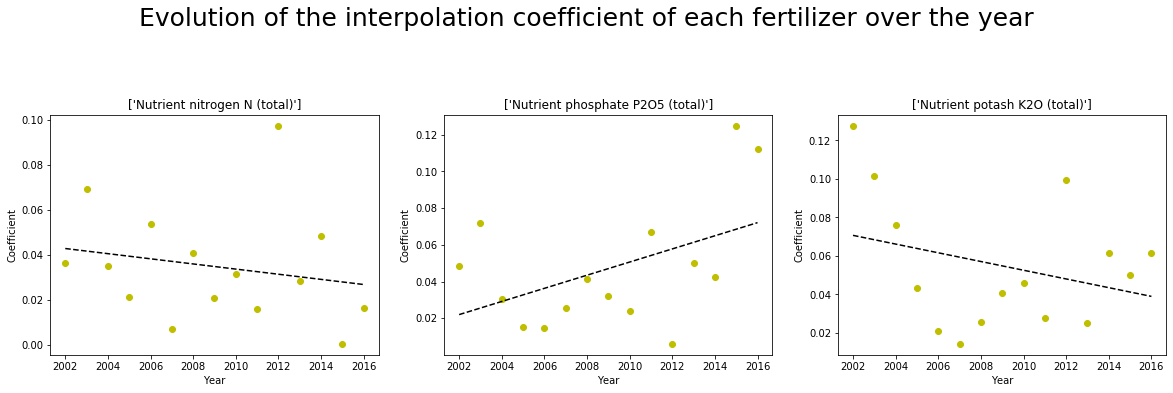

In [38]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        umap_result=umap_year(year,3102+x,1)
        mean.append([umap_result[0],umap_result[2][0]])
    mean=pd.DataFrame(mean)
    print(stats.linregress(mean[0],mean[1]))
    
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

In [178]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge=yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_merge.reset_index(inplace=True)
    yield_for_merge=yield_for_merge.drop(columns=['index'])
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 

    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)

    embedding2=embedding2.join(yield_for_merge['Area'])

    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')

    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    embedding2['ferti_norm']=(embedding2.Value-min(embedding2.Value))/(max(embedding2.Value)-min(embedding2.Value))
    coef = np.polyfit(embedding2['Umap'],embedding2.ferti_norm,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

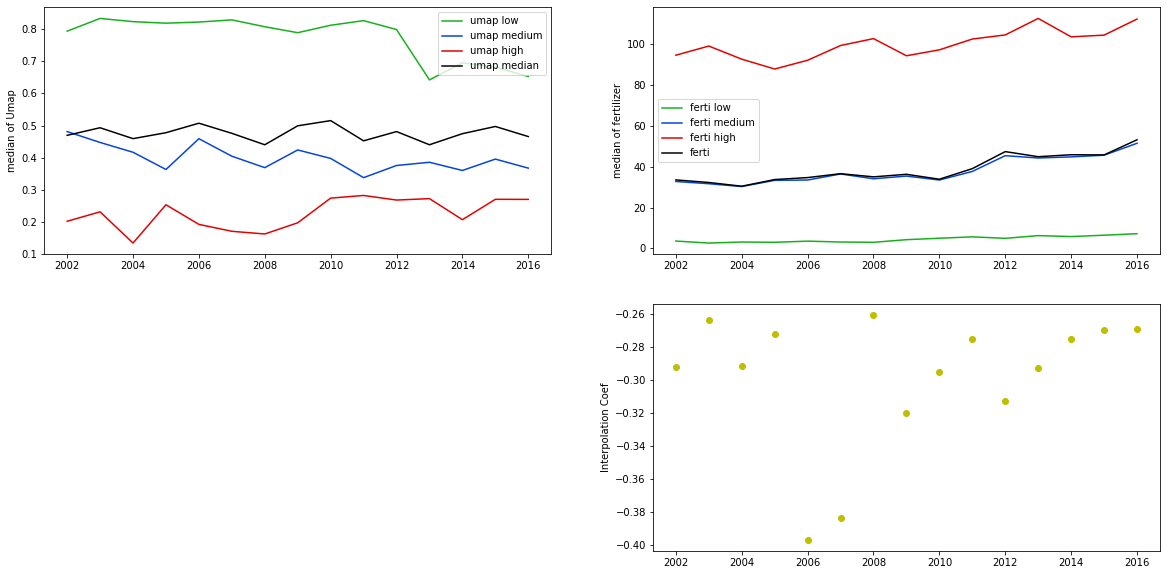

In [179]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    umap_result=umap_year(year,3102,1)
    low_median=umap_result[1].Value[umap_result[1].ferti_class=='low'].median()
    medium_median=umap_result[1].Value[umap_result[1].ferti_class=='medium'].median()
    high_median=umap_result[1].Value[umap_result[1].ferti_class=='high'].median()
    ferti_median=umap_result[1].Value.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].ferti_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].ferti_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].ferti_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,ferti_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','ferti low','ferti medium','ferti high','ferti',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "ferti low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "ferti medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "ferti high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "ferti", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

# PCA

In [42]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [43]:
def PCA_year(year, ferti_code):
    grouped_yield=(crops
            .query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    
    fertilizer=(fertilizer_area
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .query('`Item Code` == @ferti_code')
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.Value=(grouped_yield_pca.Value-min(grouped_yield_pca.Value))/(max(grouped_yield_pca.Value)-min(grouped_yield_pca.Value))
    
    
    
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)

    return year,grouped_yield_pca,coef # return year (for confirmation), performed PCA and value of linear regression

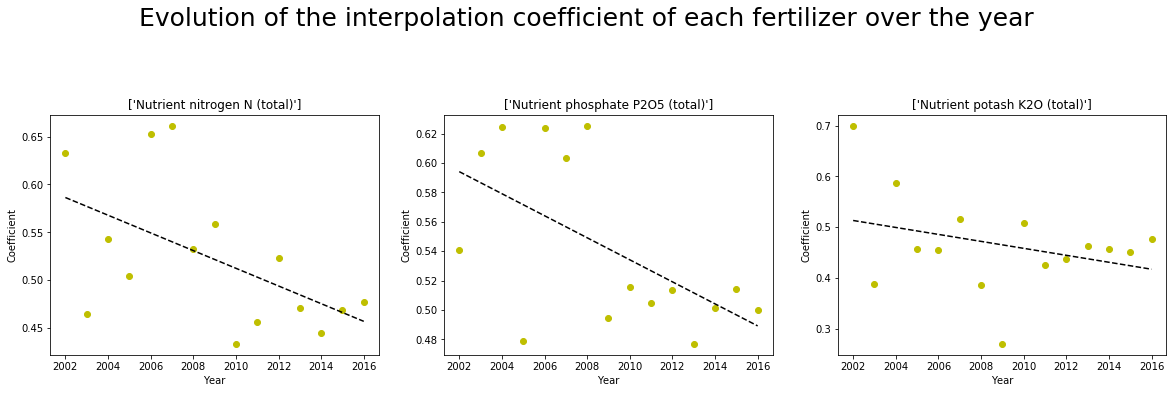

In [44]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        adding=PCA_year(year,3102+x)
        mean.append([adding[0],adding[2][0]])
    mean=pd.DataFrame(mean)
    
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

## Victor code modified ( normalization before polyfit and dropna added)

In [137]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
ferti_low = []
ferti_medium = []
ferti_high = []
ferti = []
fertilizer_effect = []
proportion_explained = []


for year in range(2002,2016):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
        .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reindex()
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
    )
    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))
    
    PC1_low += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'].median()]
    PC1_medium += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'].median()]
    PC1_high += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high'].median()]
    PC1 += [grouped_yield_pca.PC1.median()]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    ferti_low += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low'].median()]
    ferti_medium += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium'].median()]
    ferti_high += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high'].median()]
    
    ferti += [grouped_yield_pca.Value.median()]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    
    fertilizer_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

In [138]:
grouped_yield.head()

Item,Area,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary,Cereal
0,Afghanistan,89744,6586.77,3914.15,7443,130903,98165,19665.333333
1,Albania,214057,8354.46,6066.42,13829,242574,253610,51670.000000
2,Algeria,113518,10612.7,3366.65,10263,296099,205598,13558.333333
4,Angola,221328,2371.58,2464.85,5132,99626,33032,9771.000000
6,Argentina,175009,18864,4738.73,13537,246030,177960,52403.000000


Text(0, 0.5, 'fertilizer effect')

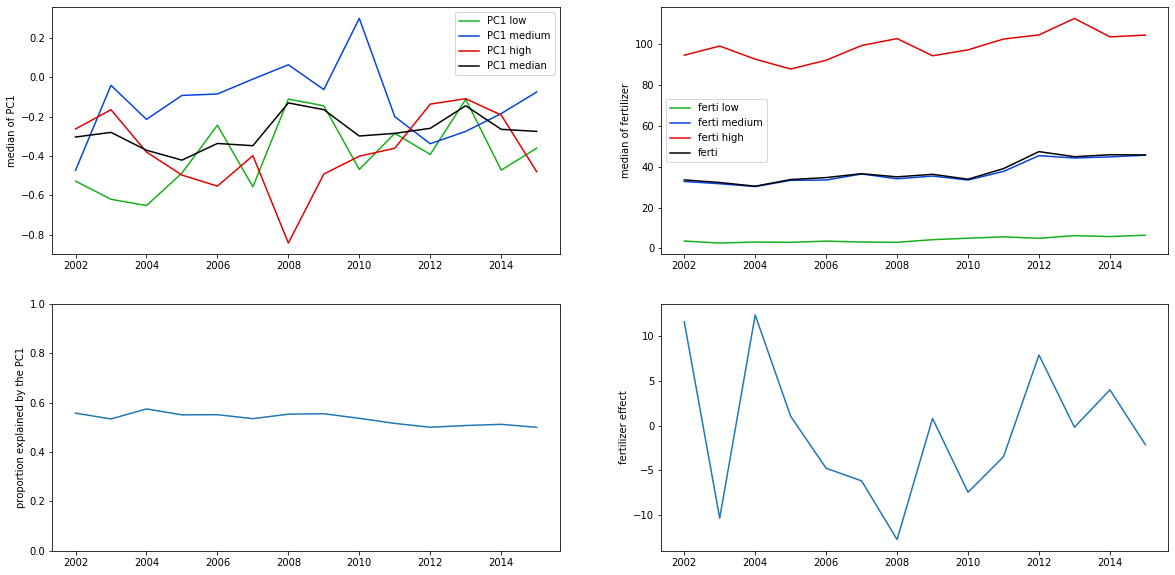

In [139]:
evolution_ferti = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, ferti_medium, ferti_high,ferti,PC1, proportion_explained, fertilizer_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','ferti low', 'ferti medium', 'ferti high','ferti','PC1 median', 'proportion explained', 'fertilizer_effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "ferti low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "ferti medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "ferti high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "ferti", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'fertilizer_effect', data=evolution_ferti)
ax4.set_ylabel('fertilizer effect')

# Boxplot ferti distrib over the years
(I was afraid that the tree groups median would become similar over the year (and thus making our visualization over the year for the 3 groups biased).
So here is visualization of fertilizer use distribution over the year

In [50]:
ferti_box=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    ferti=(fertilizer_area
            .query('`Year Code` == @year')
            .query('`Item Code` ==3102')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item Code',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    ferti.rename(columns={3102:str(year)},inplace=True)
    ferti['ferti_class'+str(year)]=ferti[str(year)].apply(lambda x: ferti_class(x, ferti[str(year)]))
    ferti.dropna(axis=0, inplace=True)
    ferti_box=ferti.merge(ferti_box,on='Area',how='outer')
    
ferti_box.head(1)

,Area,2016,ferti_class2016,2015,ferti_class2015,2014,ferti_class2014,2013,ferti_class2013,2012,...,2006,ferti_class2006,2005,ferti_class2005,2004,ferti_class2004,2003,ferti_class2003,2002,ferti_class2002
0,Afghanistan,11.71,low,11.71,low,11.71,low,14.45,low,27.58,...,6.2,low,3.17,low,2.96,low,2.57,low,3.02,low


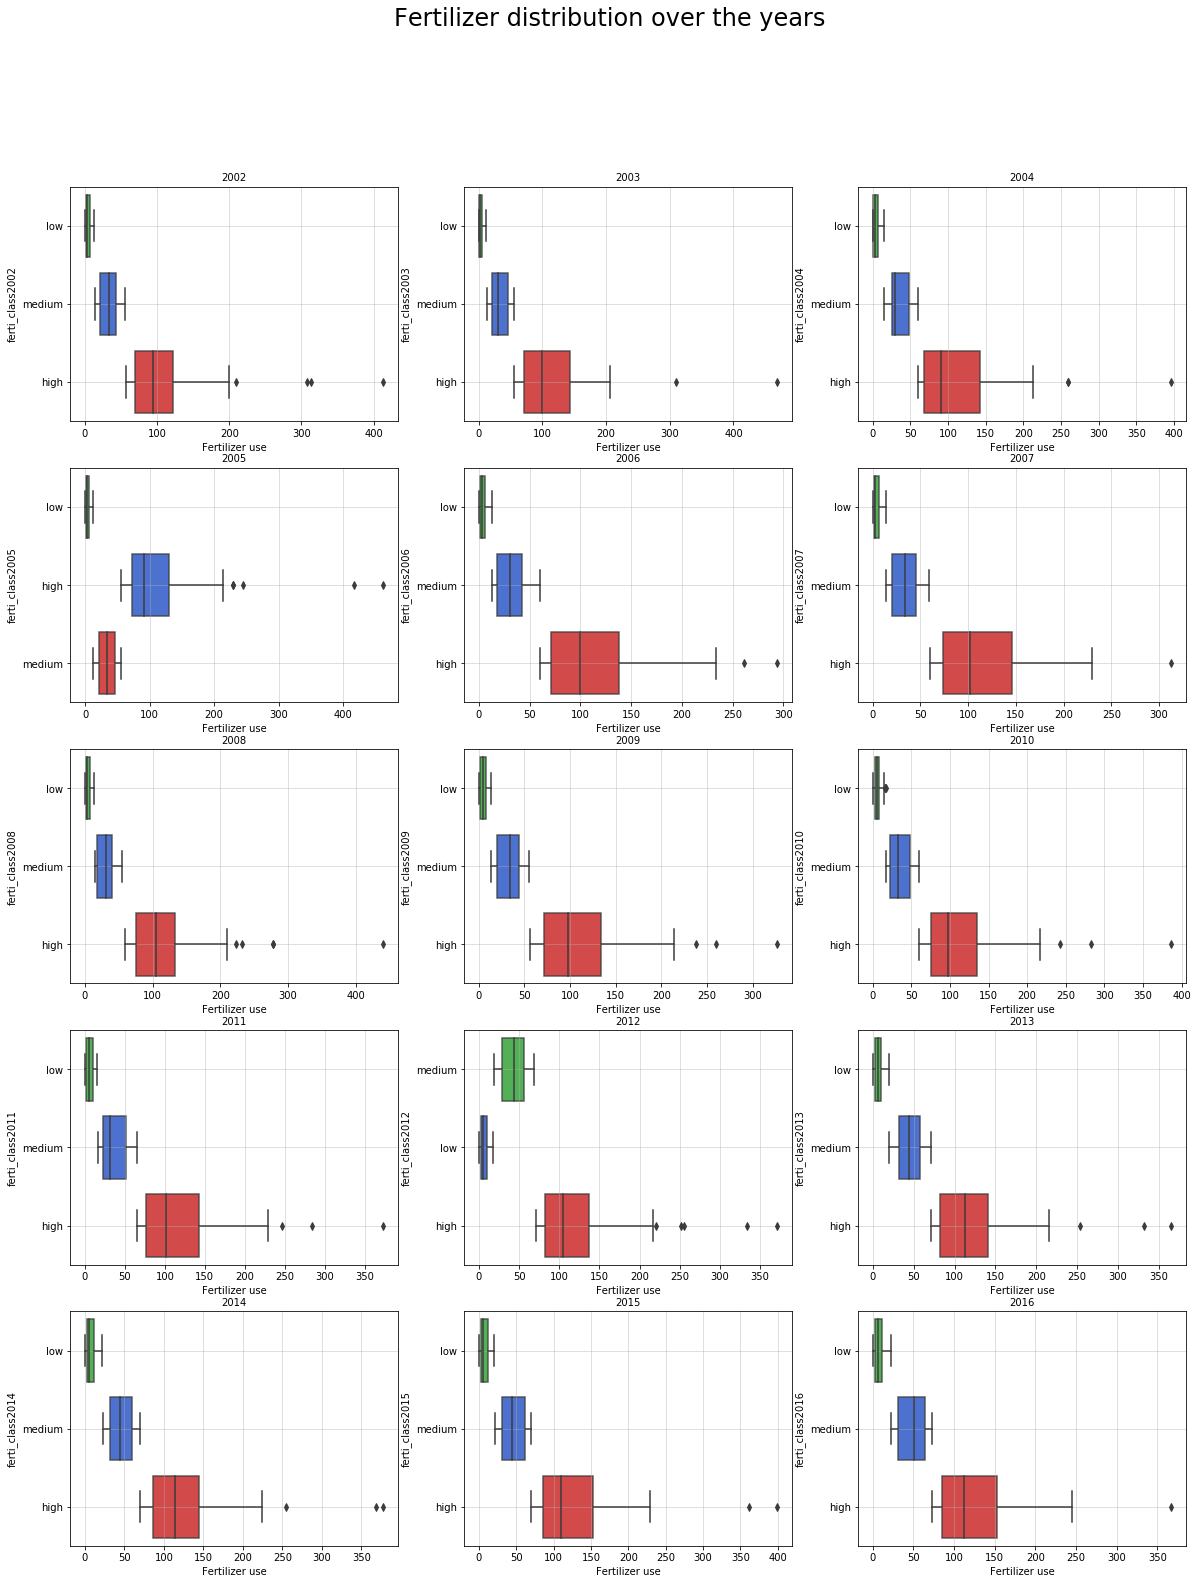

In [51]:
colors = ["green", "blue", "red"]
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Fertilizer distribution over the years', fontsize=24)
for x in range (n) : 
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    ax1 = sns.boxplot(x=str(x+2002), y='ferti_class'+str(x+2002), data=ferti_box, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
    ax1.grid(alpha=0.5)
    plt.xlabel('Fertilizer use')
    plt.title(str(x+2002), fontsize=10);

We can see that expect for year 2005 and 2012, the distribution stay similar. Thus it's correct to use median of the tree groups over the year as previously did

# Dataframe for map (Clélie) 

In [52]:
#yield dataframe
yield_indic=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    grouped_yield=(crops
            .query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    yield_indic=yield_indic.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
yield_indic.head(5)

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,0.192083,0.176489,0.157921,0.192136,0.180154,0.221830,0.189656,0.201427,0.173985,0.180454,0.185093,0.206770,0.172721,0.174471,0.151521
1,Albania,0.380818,0.396188,0.360753,0.424086,0.452897,0.462366,0.470982,0.490245,0.559344,0.600552,0.555888,0.566601,0.561338,0.580907,0.543501
2,Algeria,0.153568,0.210995,0.186330,0.228890,0.211762,0.192537,0.186886,0.237562,0.226247,0.275239,0.264424,0.301986,0.249308,0.267187,0.224545
3,Angola,0.056573,0.047703,0.032109,0.068867,0.034405,0.064708,0.086612,0.055735,0.042078,0.078238,0.015694,0.075804,0.060570,0.068871,0.060810
4,Argentina,0.483060,0.568530,0.489784,0.581575,0.563065,0.629194,0.559385,0.439919,0.622958,0.632591,0.532113,0.591889,0.584835,0.612951,0.585793


In [53]:
yield_indic.shape[0]

70

In [54]:
def replace_values_geojson(df):
    new_df = df
    new_df[new_df.Area == 'Russian Federation'] = df[df.Area == 'Russian Federation'].replace('Russian Federation', 'Russia')
    new_df[new_df.Area == 'Bolivia (Plurinational State of)'] = df[df.Area == 'Bolivia (Plurinational State of)'].replace('Bolivia (Plurinational State of)', 'Bolivia')
    new_df[new_df.Area == 'Venezuela (Bolivarian Republic of)'] = df[df.Area == 'Venezuela (Bolivarian Republic of)'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
    new_df[new_df.Area == 'Côte d\'Ivoire'] = df[df.Area == 'Côte d\'Ivoire'].replace('Côte d\'Ivoire', 'Ivory Coast')
    new_df[new_df.Area == 'Congo'] = df[df.Area == 'Congo'].replace('Congo', 'Republic of the Congo')   
    new_df[new_df.Area == 'Republic of Moldova'] = df[df.Area == 'Republic of Moldova'].replace('Republic of Moldova', 'Moldova')
    new_df[new_df.Area == 'Syrian Arab Republic'] = df[df.Area == 'Syrian Arab Republic'].replace('Syrian Arab Republic', 'Syria')
    new_df[new_df.Area == 'Iran (Islamic Republic of)'] = df[df.Area == 'Iran (Islamic Republic of)'].replace('Iran (Islamic Republic of)', 'Iran')
    new_df[new_df.Area == 'Viet Nam'] = df[df.Area == 'Viet Nam'].replace('Viet Nam', 'Vietnam')
    new_df[new_df.Area == 'Lao People\'s Democratic Republic'] = df[df.Area == 'Lao People\'s Democratic Republic'].replace('Lao People\'s Democratic Republic', 'Laos')
    new_df[new_df.Area == 'Democratic People\'s Republic of Korea'] = df[df.Area == 'Democratic People\'s Republic of Korea'].replace('Democratic People\'s Republic of Korea', 'North Korea')
    new_df[new_df.Area == 'Republic of Korea'] = df[df.Area == 'Republic of Korea'].replace('Republic of Korea', 'South Korea')
    new_df[new_df.Area == 'Serbia'] = df[df.Area == 'Serbia'].replace('Serbia', 'Republic of Serbia')
    new_df[new_df.Area == 'The former Yugoslav Republic of Macedonia'] = df[df.Area == 'The former Yugoslav Republic of Macedonia'].replace('The former Yugoslav Republic of Macedonia', 'Macedonia')
    new_df[new_df.Area == 'China, Taiwan Province of'] = df[df.Area == 'China, Taiwan Province of'].replace('China, Taiwan Province of', 'Taiwan')
    return(new_df)

In [182]:
# Load the GeoJson file containing the name, id and geometry of each country
df = gpd.read_file("./countries.geo.json")

# Make some changes in the names of the countries in the dataset to make them match with the GeoJson file
yield_indic2 = replace_values_geojson(yield_indic)

# Make sure that the name of the countries in your dataframe is 'name' as in the GeoJson file
yield_indic2 = yield_indic.rename(columns={'Area': 'name'})

# Merge the geometry of the countries to the yield DataFrame
yield_indic2.drop_duplicates(inplace=True)
df_final = df.merge(yield_indic2, on='name', how='left')

# Here, you should have a dataframe with a column name, a column id, a column geometry, and one column per year per the infrmation you want to show
# Plot the production on an interactive map
years = range(2002,2017) # Check that it corresponds to your year range     
slider_columns = [str(i) for i in years]  # Replace it with the names of your column( should be given as a list)

yield_map = df_final.plot_bokeh(
            figsize = (900,600),
            simplify_shapes=10000,
            slider = slider_columns,
            slider_range = years,
            slider_name = 'Year',
            colormap = 'Inferno',
            hovertool_columns = ['id']+slider_columns,
            title='carte.html'
            )

output_file("carte.html")
save(yield_map)

NameError: name 'output_file' is not defined

In [61]:
#ferti dataframe
ferti_year=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    ferti=(fertilizer_area
            .query('`Year Code` == @year')
            .query('`Item Code` ==3102')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item Code',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    ferti.rename(columns={3102:str(year)},inplace=True)
    ferti.dropna(axis=0, inplace=True)
    
    ferti_year=ferti.merge(ferti_year,on='Area',how='outer')
ferti_year.head(5)

,Area,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,11.71,11.71,11.71,14.45,27.58,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.960000,2.57,3.02
1,Albania,60.98,52.87,44.13,44.11,49.95,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.190000,53.15,54.34
2,Algeria,11.53,11.83,12.25,7.79,7.89,7.51,8.43,5.69,2.75,4.37,5.23,0.49,12.620000,2.07,3.42
3,Angola,4.89,4.91,5.32,3.94,3.89,3.28,3.96,2.44,2.21,1.51,1.85,1.03,2.000000,0.50,0.81
4,Antigua and Barbuda,8.76,1.70,4.12,6.48,5.34,0.80,0.80,4.60,1.80,0.40,1.80,3.40,2.542595,6.60,2.00


# Rank 5 better countries :


In [66]:
# Rank by PCA score
yield_indic.sort_values(by='2011',ascending=False).loc[:,['Area','2009']].head(5)


,Area,2009
65,United States of America,0.941881
23,France,1.000000
34,Israel,0.643974
12,Chile,0.625263
19,Egypt,0.785810


In [63]:
# Rank by Umap score
umap_result=umap_year(2009,3102,1)
umap_result[1].sort_values(by='Umap',ascending=False).loc[:,['Area','Umap']].head(5)

164
154


,Area,Umap
25,Canada,1.000000
35,Côte d'Ivoire,0.950111
69,Kenya,0.949093
36,Democratic Republic of the Congo,0.947065
48,France,0.943777


In [64]:
# Rank by fertilizer use
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == 2009')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )
fertilizer.loc[:,['Area','Value']].head(5)

,Area,Value
2023,Egypt,326.82
6383,United Arab Emirates,259.73
1359,"China, mainland",237.47
4591,Oman,213.82
3602,Luxembourg,211.34


The only value shared by both dataframes is Egypt which has the better place (but only using the Umap ranking). It correspond to the black point on the diagram "Nitrogen Use by umap projection over the year" previously displayed (in the Umap part).